# A custom toy Dataset for segmentation

We are going to define a simple segmentation dataset based on MNIST. For that, we are borrowing some ideas from [this](https://colab.research.google.com/github/LukeTonin/simple-deep-learning/blob/18005bf4cfe0d67470a0b80b763fb0565c8cfcac/mnist_extended.ipynb) notebook.

In [ ]:
# Connect to drive

from google.colab import drive
import os

drive.mount('/content/gdrive')

project_path = '/content/gdrive/MyDrive/AMLCV/P2/tutorial'
os.chdir(project_path)


Mounted at /content/gdrive


The dataset uses augmented MNIST as base, and places the numbers randomly into a larger image of size MxM, while generating ground truth segmentations of de digits using 11 clases: 0 for background, and 1 to 10 for each of the digits from 0 to 9.

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import torch
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

class SegmentationMNIST(Dataset):
  def __init__(self, root:str, train:bool, image_size=(128,128), transform=None, target_transform = None, ndigits = (5,8), max_iou=0.1):
    """
    Args:
    - root: the route for the MNIST dataset. It will be downloaded if it does not exist
    - train: True for training set, False for test set
    - image_size: tuple with the dataset image size
    - transform: the transforms to be applied to the input image
    - target_transform: the transforms to be applied to the label image
    - ndigits: tuple with the mininum and maximum number of digits per image
    - max_iou: maximum IOU between digit bounding boxes
    """

    self.transform = transform
    self.target_transform = target_transform
    self.image_template = torch.zeros((1, *image_size), dtype=torch.float32)
    self.target_tempalte = torch.zeros((1, *image_size), dtype=torch.uint8)
    self.max_iou = 0.2

    mnist_transform = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.5,1.5), shear=30),
        transforms.Resize(48),
        transforms.ToTensor()
    ])

    self.mnist = datasets.MNIST(root, train, download=True, transform = mnist_transform)
    self.index = random.permutation(len(self.mnist))

    # Compute the number of digits in each image, and the total number of images
    self.num_digits = []
    remaining = len(self.mnist)
    while remaining > ndigits[1]+ndigits[0]:  # The remaining will be from min to max, i.e. one image
      this_num = random.randint(ndigits[0], ndigits[1])
      self.num_digits.append(this_num)
      remaining -= this_num
    self.num_digits.append(remaining)

    self.num_digits = np.array(self.num_digits)
    self.start_digit = self.num_digits.cumsum() - self.num_digits[0]

  def __len__(self):
    return len(self.num_digits)
  
  def __getitem__(self, idx):
    sample = self.image_template.detach().clone()
    target = self.image_template.detach().clone()

    for i in range(self.num_digits[idx]):
      digit, cls = self.mnist[self.start_digit[idx]+i]
      mask = digit>0

      valid = False
      while not valid: 
        y = random.randint(0, sample.size(1)-digit.size(1))
        x = random.randint(0, sample.size(2)-digit.size(2))
        valid = (mask*sample[:, y:y+digit.size(1), x:x+digit.size(2)]>0).sum() < self.max_iou*mask.sum()

      sample[:,y:y+digit.size(1), x:x+digit.size(2)][mask] = digit[mask]
      target[:,y:y+digit.size(1), x:x+digit.size(2)][mask] = cls+1

      if self.transform is not None:
        sample = self.transform(sample)
      if self.target_transform is not None:
        target = self.target_transform(target)

    return (sample, target)



    



In [ ]:
training = SegmentationMNIST(os.getcwd(), train=True )

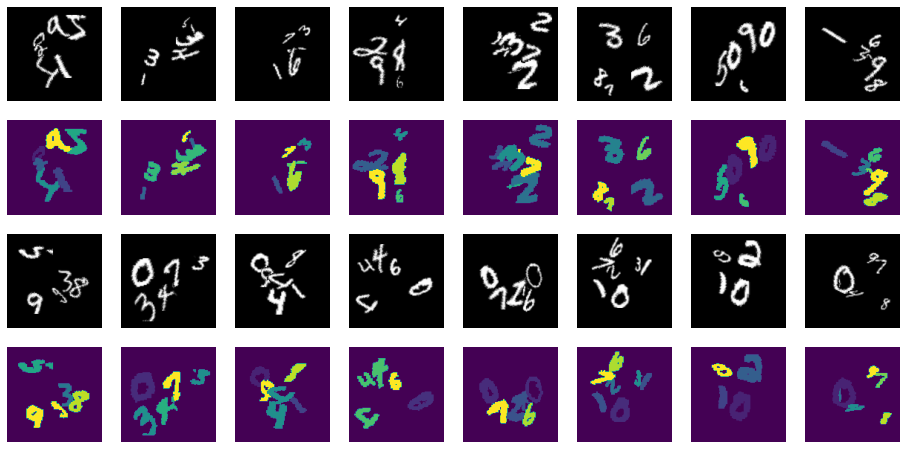

In [ ]:
rows = 2
cols = 8

size_each = 2
fig, axes = plt.subplots(rows*2, cols,figsize =(cols*size_each, rows*2*size_each) )

for ax in axes.reshape(-1):
  ax.axis('off')

counter = 0
for r in range(rows):
  for c in range(cols):
    sample, label = training[counter]
    counter += 1
    axes[r*2][c].imshow(sample[0,...], cmap='gray')
    axes[r*2+1][c].imshow(label[0,...]/10)
